Halil Hamscho (UT EID: hh27965)
Tofik Hamscho (UT EID: th33237)

## C S 329E Term Project: Yelp Dataset


Source: [www.yelp.com/dataset](https://www.yelp.com/dataset)

<h3>Project Description: Unveiling Hidden Culinary Gems</h3>
<h4>Research Goal/Question</h4>
<p><strong>Objective:</strong> To uncover potentially hidden or underrated food spots in cities that are popular travel destinations, leveraging Yelp's extensive data on reviews and ratings.</p>
<h4>Dataset Overview</h4>
<p><strong>Source:</strong> Utilizing Yelp's comprehensive dataset, the analysis focuses on lesser-known establishments by examining review counts and ratings. The dataset includes various business attributes such as location, star ratings, number of reviews, and other relevant attributes that may influence a venue's popularity and perceived quality.</p>
<h4>Data Cleaning and Preparation</h4>
<p><strong>Scope:</strong> The analysis targets a specific city to ensure relevance for potential visitors or local explorers. Key steps in data preparation include:</p>
<ul>
  <li><strong>Low review counts:</strong> Filtering for establishments that are not overly popular or mainstream.</li>
  <li><strong>High ratings:</strong> Ensuring that, despite lower popularity, the establishments maintain high customer satisfaction.</li>
  <li><strong>Relevant attributes:</strong> Considering factors like ambiance, accessibility, and service types to cater to niche audiences.</li>
</ul>
<h4>Learning Model</h4>
<p><strong>Methodology:</strong></p>
<ul>
  <li><strong>Clustering:</strong> Employing clustering techniques to find patterns in geographical locations and ratings, aiming to group similar eateries that might qualify as hidden gems.</li>
</ul>
<h4>Expectations</h4>
<p><strong>Hypothesis:</strong> The project expects to identify clusters or groups of high-rated but seldom-reviewed restaurants, potentially indicating spots well-regarded by locals or connoisseurs but not yet widely recognized.</p>
<h4>Evaluation Strategy</h4>
<p><strong>Metrics:</strong></p>
<ul>
  <li><strong>Exploratory Analysis:</strong> Since the project is exploratory, the primary evaluation focuses on the utility, relevance, and uniqueness of the identified spots.</li>
  <li><strong>Silhouette Score:</strong> For clustering models, the silhouette score will be used to assess the degree of similarity an object has to its own cluster compared to other clusters, providing a measure of how well-separated and tight the clusters are.</li>
  <li><strong>Cross-Validation with Multiple Models:</strong> Validating findings by comparing results across different clustering methods such as K-Means, PCA, DBSCAN, and Hierarchical Clustering to ensure consistency and reliability in the identified patterns.</li>
</ul>


In [19]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline

In [20]:
file_path = 'yelp_academic_dataset_business.json'

# Load the data
business_data = pd.read_json(file_path, lines=True)

# Display the first few rows of the dataframe to confirm it's loaded correctly
print(business_data.head())

              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.9555

<h3> Find What City Has the Most Reviews </h3>

In [21]:
# Count the number of business entries per city
city_counts = business_data['city'].value_counts()

# Find the city with the most entries
top_cities = city_counts.head(10)

print(top_cities)


city
Philadelphia     14569
Tucson            9250
Tampa             9050
Indianapolis      7540
Nashville         6971
New Orleans       6209
Reno              5935
Edmonton          5054
Saint Louis       4827
Santa Barbara     3829
Name: count, dtype: int64


We will be choosing New Orleans as the desired city as we have previously visited it and in our next visit, we want to be much more prepared. 

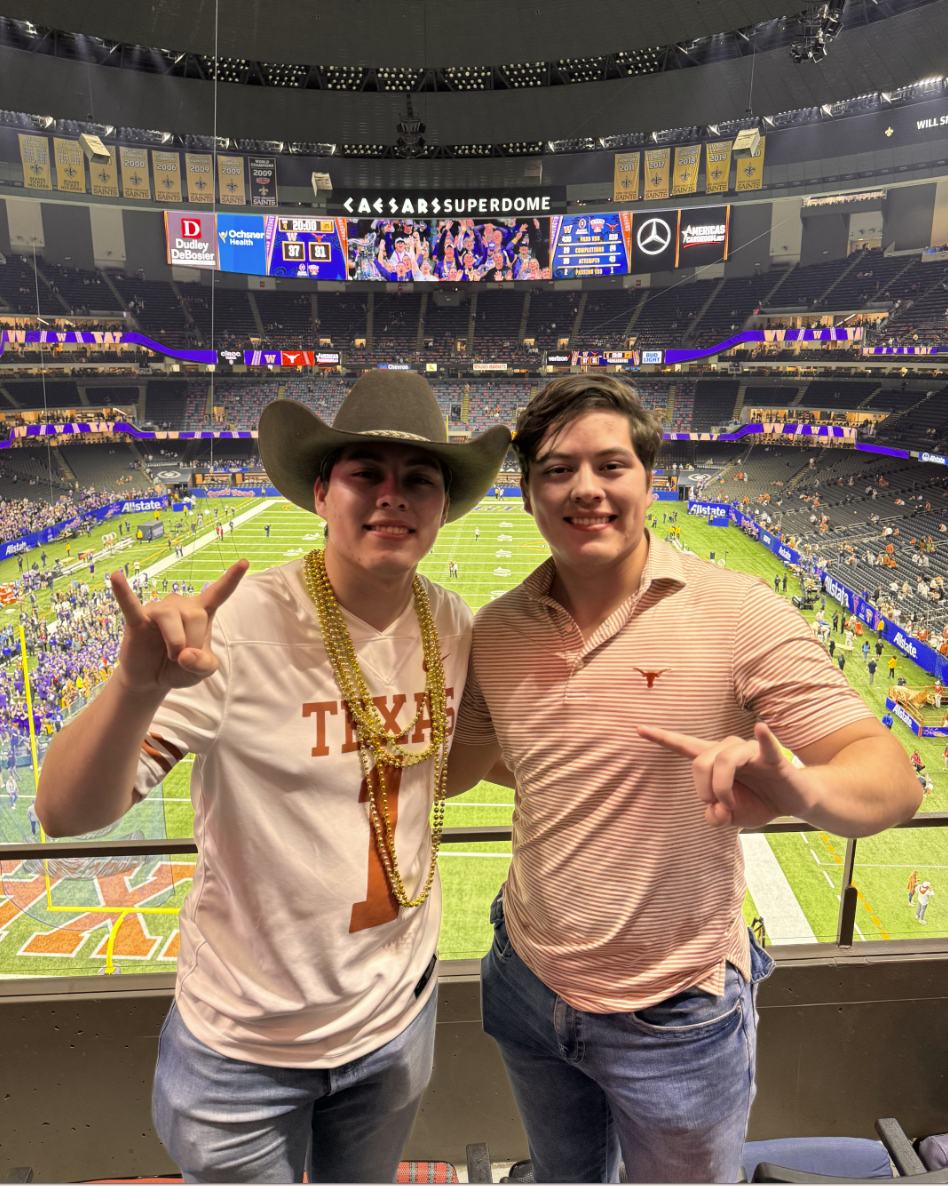

# Introduction
This project aims to identify hidden gems in New Orleans' restaurant scene using clustering techniques. We define hidden gems as highly-rated businesses that are not widely popular. The effectiveness of our clustering approach is evaluated using the silhouette score, which helps in assessing how similar an object is to its cluster compared to other clusters.

<h3>Step #1: Clean, Prepare and Filter Data

<h3>Obtain Only New Orleans Businesses

In [22]:
import pandas as pd

# Load the dataset
file_path = 'yelp_academic_dataset_business.json'
business_data = pd.read_json(file_path, lines=True)

# Filter for businesses in New Orleans, case-insensitive
new_orleans_businesses = business_data[
    (business_data['city'].str.lower() == 'new orleans') & (business_data['state'] == 'LA')
]

filtered_businesses = new_orleans_businesses

<h3>Obtain the Top Categories of all Establishments

In [23]:
# Extract all categories from the business data
all_categories = pd.Series(','.join(business_data['categories'].dropna()).split(','))

# Convert all category names to lower case and strip whitespace
all_categories = all_categories.str.lower().str.strip()

# Get the frequency of each category
category_counts = all_categories.value_counts()

# Display the most common categories
print(category_counts.head(500))


restaurants          52268
food                 27781
shopping             24395
home services        14356
beauty & spas        14292
                     ...  
modern european        131
country clubs          131
boxing                 131
stadiums & arenas      130
life coach             130
Name: count, Length: 500, dtype: int64


<h3>Filter by only food-related categories

In [24]:
# Define a more comprehensive list of food-related categories based on the most common ones in your dataset
food_related_categories = [
    'restaurants', 'food', 'cafes', 'bakeries', 'bars', 'coffee & tea', 
    'ice cream', 'frozen yogurt', 'sandwiches', 'burgers', 'brunch', 'creole', 'lunch', 'dinner',
    'mexican', 'tex-mex', 'american (traditional)', 'american (new)', 'pizza', 'breakfast & brunch', 
    'seafood', 'fast food', 'italian', 'specialty food', 'chinese', 'desserts', 'chicken wings', 
    'salad', 'beer', 'wine & spirits', 'delis', 'steakhouses', 'sushi bars', 'barbeque', 
    'juice bars & smoothies', 'caterers', 'gastropubs', 'mediterranean', 'thai', 'cajun/creole',
    'japanese', 'pubs', 'cocktail bars', 'vegetarian', 'vegan', 'vietnamese', 'greek', 'southern', 
    'gluten-free', 'french', 'indian', 'latin american', 'korean', 'asian fusion', 'middle eastern',
    'caribbean', 'spanish', 'tapas/small plates', 'soul food', 'comfort food', 'halal', 'pasta shops', 
    'diners', 'food trucks', 'brewpubs', 'breweries', 'wine bars', 'beer gardens', 'sports bars', 
    'dive bars', 'hot dogs', 'tacos', 'buffets', 'ramen', 'poke', 'ethic food', 'dim sum', 'tapas bars'
]

# Further filter businesses based on the comprehensive list of categories, case-insensitive
filtered_businesses = new_orleans_businesses[
    new_orleans_businesses['categories'].str.lower().str.contains('|'.join(food_related_categories), na=False)
]

# Handle missing values in critical fields
filtered_businesses = filtered_businesses.dropna(subset=['stars', 'review_count'])

# Define hidden gems as highly rated but not widely reviewed
median_review_count = filtered_businesses['review_count'].median()
hidden_gems = filtered_businesses[
    (filtered_businesses['stars'] >= 4) & 
    (filtered_businesses['review_count'] < median_review_count) &
    (filtered_businesses['is_open'] == 1)
]

# Display the prepared DataFrame
print(hidden_gems.head())

                business_id                             name  \
96   J_ksUDPpzPwfTGtI4zTRnQ                   Riverview Room   
324  IOZrqUQ2Jg6UeQ5CWpsmkg  Nesbit's Magazine Street Market   
385  vFJIK-z3QWs-3XNjs1hcZQ          New Orleans Jazz Market   
864  yUcMPv-B9gCUUNT-GUiJbw                The flagpole Nola   
870  MC5pczUOBUN-0MtJAYk46Q                  Cupcake Fairies   

                           address         city state postal_code   latitude  \
96                  600 Decatur St  New Orleans    LA       70130  29.955925   
324                301 Magazine St  New Orleans    LA       70130  29.950477   
385  1436 Oretha Castle Haley Blvd  New Orleans    LA       70113  29.941159   
864             2023 Esplanade Ave  New Orleans    LA       70116  29.972475   
870                  2511 Bayou Rd  New Orleans    LA       70119  29.976258   

     longitude  stars  review_count  is_open  \
96  -90.062962    4.5             7        1   
324 -90.067944    5.0             7   

C:\Users\Halil Hamscho\AppData\Local\Temp\ipykernel_30640\145850581.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_orleans_businesses['categories'].str.lower().str.contains('|'.join(food_related_categories), na=False)


<h3>Step #2: Implement clustering 

In [25]:
# Step 1: Feature extraction and preparation
features = hidden_gems[['stars', 'review_count']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 2: Clustering
kmeans = KMeans(n_clusters=9, random_state=123)
clusters = kmeans.fit_predict(features_scaled)

# Instead of hidden_gems['cluster'] = clusters
hidden_gems.loc[:, 'cluster'] = clusters


# Step 3: Evaluation
score = silhouette_score(features_scaled, clusters)
print('Silhouette Score:', score)
print()


Silhouette Score: 0.6313035066032046



C:\Users\Halil Hamscho\AppData\Local\Temp\ipykernel_30640\2783528426.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hidden_gems.loc[:, 'cluster'] = clusters


<h3>Experimenting with Different Cluster Counts

In [26]:
# Experiment with different cluster counts
for k in range(2, 10):  # Example range, adjust based on your exploration
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=123)
    clusters = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, clusters)
    print(f'Silhouette Score with {k} clusters:', score)

Silhouette Score with 2 clusters: 0.381052126605522
Silhouette Score with 3 clusters: 0.4741361635377607
Silhouette Score with 4 clusters: 0.5165802135285446
Silhouette Score with 5 clusters: 0.5612679072641448
Silhouette Score with 6 clusters: 0.5866052816335336
Silhouette Score with 7 clusters: 0.6056337850707086
Silhouette Score with 8 clusters: 0.6257356610144027
Silhouette Score with 9 clusters: 0.6340008677296582


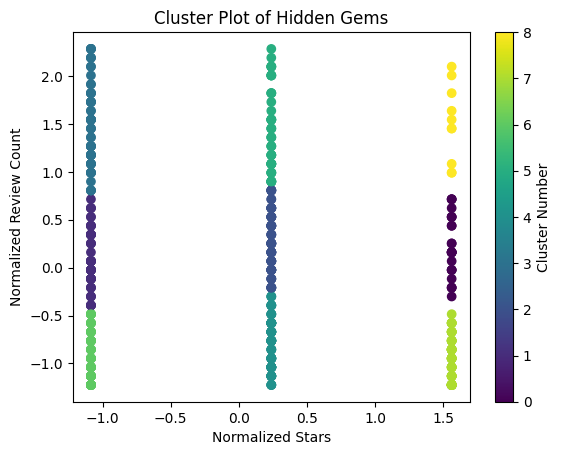

In [27]:
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=clusters, cmap='viridis', label=clusters)
plt.xlabel('Normalized Stars')
plt.ylabel('Normalized Review Count')
plt.title('Cluster Plot of Hidden Gems')
plt.colorbar(label='Cluster Number')  # Adds a color bar to map colors to cluster numbers
plt.show()

<h4> Description </h4>
This graph is a visual representation of the clusters identified by the KMeans clustering algorithm when applied to the Yelp dataset. It plots the normalized scores for 'stars' and 'review count' of various businesses, with each point representing a business. The colors correspond to different clusters as identified by the algorithm. 

<h4> Interpretation of the Graph </h4>

Axes: The 'Normalized Stars' and 'Normalized Review Count' are the features we’ve used for clustering, and they've been scaled (normalized).

Normalized Stars (X-axis): How high or low the star ratings of businesses are relative to each other in the dataset after normalization.

Normalized Review Count (Y-axis): How the number of reviews per business compares relative to others after normalization.

Data Points: Each dot on the plot represents an individual business, plotted according to its star rating and review count.

Colors/Clusters: The color indicates the cluster to which each business has been assigned. The color bar on the right side of the graph shows which color corresponds to which cluster number.

Cluster Interpretation: Businesses that are close together in the graph and share the same color are considered similar in terms of their star rating and review count, as per the KMeans clustering algorithm.

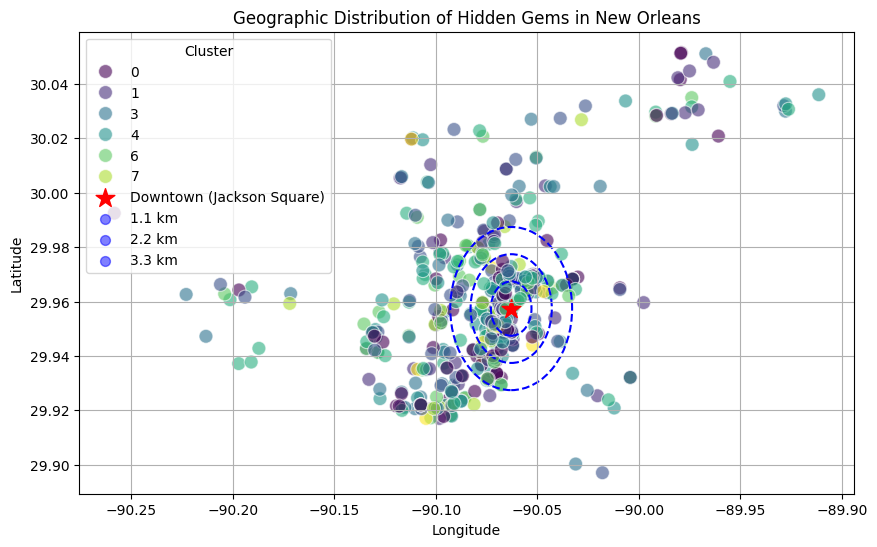

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

# Coordinates for Jackson Square, the center of New Orleans
downtown_lat, downtown_lon = 29.9574, -90.0629

# Create a scatter plot of hidden gems with downtown marker
plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get the current Axes instance on the current figure

# Plot the hidden gems
scatter = sns.scatterplot(data=hidden_gems, x='longitude', y='latitude', hue='cluster', palette='viridis', s=100, alpha=0.6)

# Add a marker for the downtown area
plt.scatter(downtown_lon, downtown_lat, color='red', s=200, label='Downtown (Jackson Square)', marker='*')

# Add circles for distance indicators
# Assuming each circle represents a fixed distance increment, e.g., 1 km
# Note: This is a simple approximation; for accurate distance calculation, consider using geospatial libraries
distances = [0.01, 0.02, 0.03]  # Approximate degrees for distances
for dist in distances:
    circle = Circle((downtown_lon, downtown_lat), dist, color='blue', fill=False, linestyle='--', linewidth=1.5)
    ax.add_patch(circle)
    plt.scatter([], [], c='blue', alpha=0.5, s=50, label=f'{dist*111:.1f} km')  # 111 km per degree latitude approximation

plt.title('Geographic Distribution of Hidden Gems in New Orleans')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

<h3>Now we only do the top 3 for each cluster and sort by proximity to jackson square

In [29]:
# Define a function to calculate the haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate distances from Jackson Square
hidden_gems['distance'] = hidden_gems.apply(
    lambda x: haversine(downtown_lat, downtown_lon, x['latitude'], x['longitude']), axis=1
)

# Sort by distance within each cluster and select the top 3 closest businesses
top_3_per_cluster = hidden_gems.sort_values(by=['cluster', 'distance']).groupby('cluster').head(3)

# Display the results
print(top_3_per_cluster[['name', 'address', 'categories', 'stars', 'review_count', 'distance']]) 

                                      name                  address  \
47219            Poppy the Suffering Vegan           736 Dumaine St   
67806   Sidewalk Food Tours of New Orleans           737 Dumaine St   
21829                     P & J Oyster Co.         1039 Toulouse St   
138353                  Big Easy Daiquiris           501 Bourbon St   
89625                                Vive!             717 Conti St   
63280          New Orleans Oyster Festival          Woldenberg Park   
67100                Tabasco Country Store         537 Saint Ann St   
88043                      House of Pepper           835 Decatur St   
83305              Abbott's Frozen Custard          628 Toulouse St   
27326                           My Bar 635           635 Bourbon St   
119128                          Saint John          1117 Decatur St   
140500                        Papa's Pizza         403 Iberville St   
30368       Creole Delicacies Gourmet Shop         533 Saint Ann St   
4321  

C:\Users\Halil Hamscho\AppData\Local\Temp\ipykernel_30640\1909724976.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hidden_gems['distance'] = hidden_gems.apply(


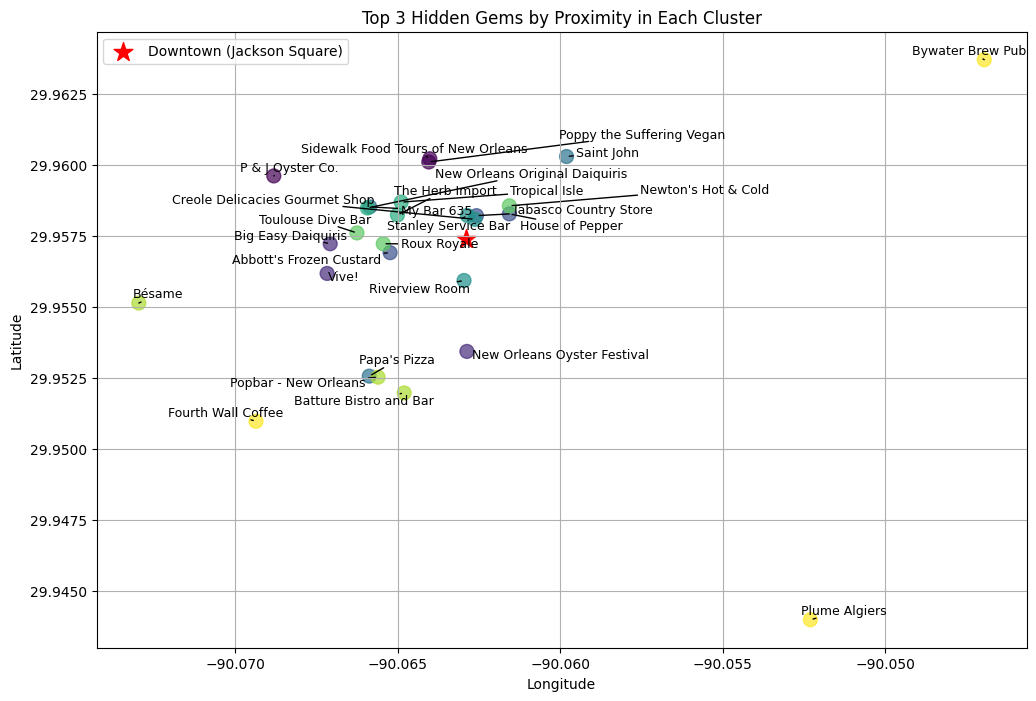

In [30]:
from adjustText import adjust_text

# Coordinates for Jackson Square, the center of New Orleans
downtown_lat, downtown_lon = 29.9574, -90.0629

plt.figure(figsize=(12, 8))
plt.scatter(top_3_per_cluster['longitude'], top_3_per_cluster['latitude'], c=top_3_per_cluster['cluster'], cmap='viridis', s=100, alpha=0.7)
plt.scatter(downtown_lon, downtown_lat, color='red', s=200, marker='*', label='Downtown (Jackson Square)')

# Prepare annotations
texts = []
for i, point in top_3_per_cluster.iterrows():
    texts.append(plt.text(point['longitude'], point['latitude'], point['name'], fontsize=9, ha='right'))

# Use adjust_text to avoid text overlapping
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

plt.title('Top 3 Hidden Gems by Proximity in Each Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()



<h1>Cross Validation #1: PCA for Feature Reduction

In [31]:
from sklearn.decomposition import PCA

features = hidden_gems[['stars', 'review_count']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


pca = PCA(n_components=2)  # Reduce to 2 principal components
features_pca = pca.fit_transform(features_scaled)

# Use these principal components for your clustering

kmeans = KMeans(n_clusters=9, random_state=123)  # Adjust clusters based on your dataset
clusters = kmeans.fit_predict(features_pca)
score = silhouette_score(features_pca, clusters)

print("Silhouette Score with PCA:", score)


Silhouette Score with PCA: 0.6313035064538789


<p><strong>Conclusion:</strong>
In our analysis, we initially considered the application of Principal Component Analysis (PCA) to reduce feature dimensionality and potentially enhance our clustering model. However, PCA is most beneficial when dealing with datasets containing a large number of features, where it serves to condense the information into a smaller set of new composite features—principal components—without significant loss of information.

Given that our dataset utilizes only two features, 'stars' and 'review_count', the application of PCA would result in two principal components, which directly correspond to our original features. In essence, PCA would not provide any dimensional reduction or substantial new insights since it would simply rotate our original data space. Therefore, applying PCA to a pair of features does not leverage its strengths and, in this context, could be considered redundant. Our clustering efforts are best served by directly using the original, interpretable features to identify hidden gems among local businesses.</p>

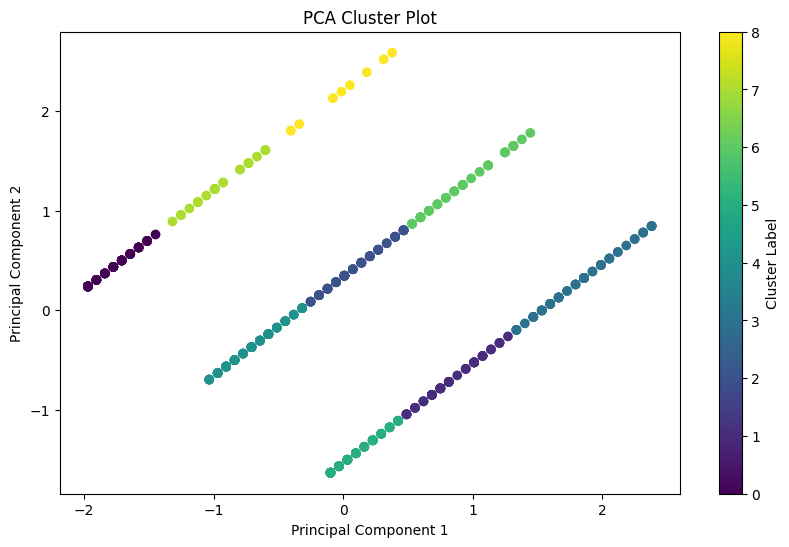

Silhouette Score with PCA: 0.6313035064538789


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming 'hidden_gems' is a DataFrame with 'stars' and 'review_count' columns
features = hidden_gems[['stars', 'review_count']].values

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Clustering with KMeans on the PCA-reduced data
kmeans = KMeans(n_clusters=9, random_state=123)
clusters = kmeans.fit_predict(features_pca)
score = silhouette_score(features_pca, clusters)

# Plot the PCA-reduced features
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.title('PCA Cluster Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Print the silhouette score
print("Silhouette Score with PCA:", score)


<h1>Cross Validation #2: Optimizing DBSCAN's Epsilon Value with Nearest Neighbors</h1>
<p>To tune the DBSCAN algorithm, one of the crucial parameters we need to optimize is the epsilon (eps), which determines the minimum distance between points to be considered part of the same neighborhood. To find an appropriate eps value, we employ the Nearest Neighbors algorithm, which helps us visualize the distance at which points connect, indicating potential cluster boundaries.</p>
<p>The graph produced plots the k-distance, which represents the distance of a point to its k<sup>th</sup> nearest neighbor—in this case, the 2nd nearest neighbor. We sort the points by their k-distance and visualize the result. What we're looking for is the point of maximum curvature on the graph, commonly referred to as the "elbow," which suggests a good eps value to use. This value is where there's a sharp turn from high to low distance, indicating that beyond this point, points are no longer densely packed and hence should not be considered part of the same cluster.</p>
<p>The k-distance graph is a heuristic method for finding a suitable eps value and requires a visual assessment. An appropriate eps is typically just beyond the elbow of the plot, where the distances start to increase more rapidly. This threshold is chosen to ensure that the density of points within a neighborhood encapsulates enough points to form a meaningful cluster, without being so large that it starts to include points from other clusters.</p>
<p>By employing this technique, we aim to enhance the DBSCAN clustering process, improving the detection of dense regions and distinguishing between the core points that form the essence of a cluster and the outliers that do not belong to any cluster.</p>

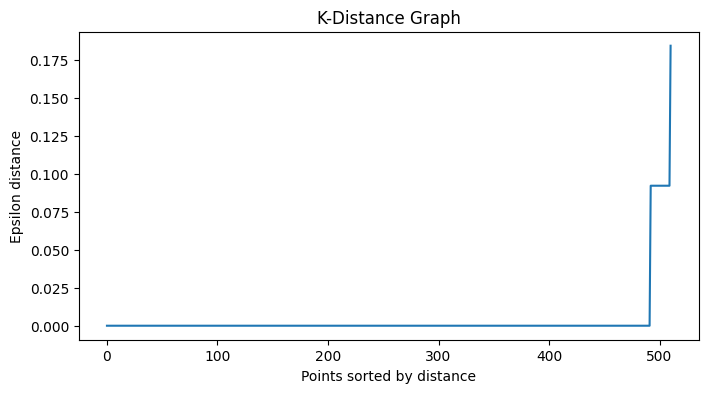

In [33]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(features_scaled)
distances, indices = neighbors_fit.kneighbors(features_scaled)

# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance')
plt.show()


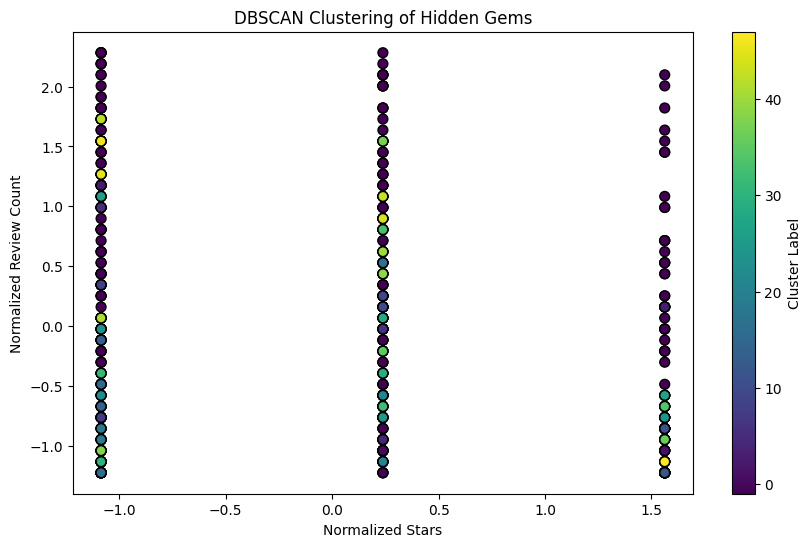

Silhouette Score for DBSCAN: 0.5094759427063036


In [34]:
from sklearn.cluster import DBSCAN

# Prepare features
features = hidden_gems[['stars', 'review_count']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)  # eps and min_samples need to be tuned based on your dataset
clusters_dbscan = dbscan.fit_predict(features_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=clusters_dbscan, cmap='viridis', edgecolor='k', s=50)
plt.title('DBSCAN Clustering of Hidden Gems')
plt.xlabel('Normalized Stars')
plt.ylabel('Normalized Review Count')
plt.colorbar(label='Cluster Label')
plt.show()

if len(set(clusters_dbscan)) > 1:  
    score_dbscan = silhouette_score(features_scaled, clusters_dbscan)
    print('Silhouette Score for DBSCAN:', score_dbscan)

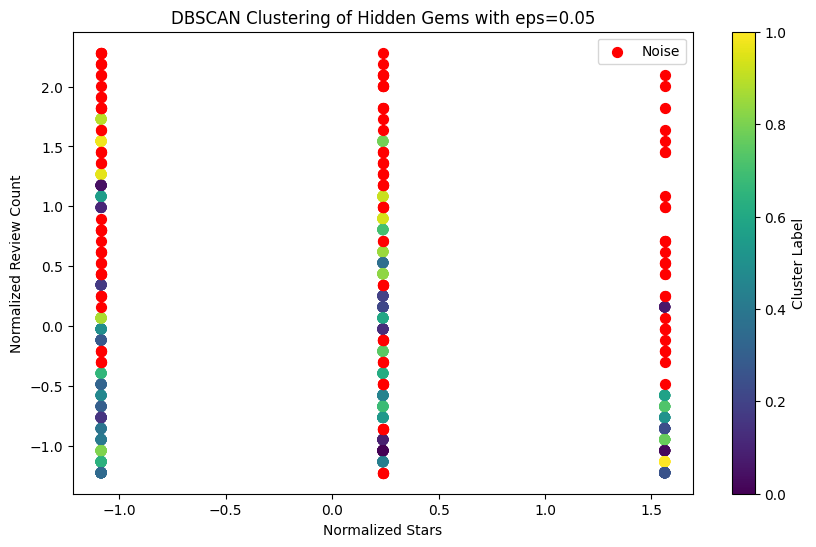

Cluster 0 Summary:
  Average Stars: 4.50
  Average Review Count: 7.00
  Number of Points: 13
----------------------------------------
Cluster 1 Summary:
  Average Stars: 5.00
  Average Review Count: 7.00
  Number of Points: 6
----------------------------------------
Cluster 2 Summary:
  Average Stars: 4.00
  Average Review Count: 31.00
  Number of Points: 7
----------------------------------------
Cluster 3 Summary:
  Average Stars: 5.00
  Average Review Count: 20.00
  Number of Points: 6
----------------------------------------
Cluster 4 Summary:
  Average Stars: 4.50
  Average Review Count: 8.00
  Number of Points: 9
----------------------------------------
Cluster 5 Summary:
  Average Stars: 4.00
  Average Review Count: 29.00
  Number of Points: 5
----------------------------------------
Cluster 6 Summary:
  Average Stars: 4.50
  Average Review Count: 18.00
  Number of Points: 8
----------------------------------------
Cluster 7 Summary:
  Average Stars: 4.00
  Average Review Count:

In [35]:
# Visualize DBSCAN Clusters
plt.figure(figsize=(10, 6))
mask = clusters_dbscan != -1  # Mask to filter out noise points
plt.scatter(features_scaled[mask, 0], features_scaled[mask, 1], c=clusters_dbscan[mask], cmap='viridis', s=50)
plt.scatter(features_scaled[~mask, 0], features_scaled[~mask, 1], c='red', s=50, label='Noise')
plt.colorbar(label='Cluster Label')
plt.title('DBSCAN Clustering of Hidden Gems with eps=0.05')
plt.xlabel('Normalized Stars')
plt.ylabel('Normalized Review Count')
plt.legend()
plt.show()

# Analyze the characteristics of each cluster
for cluster in np.unique(clusters_dbscan):
    if cluster != -1:  # Exclude noise
        cluster_data = hidden_gems[clusters_dbscan == cluster]
        print(f"Cluster {cluster} Summary:")
        print(f"  Average Stars: {cluster_data['stars'].mean():.2f}")
        print(f"  Average Review Count: {cluster_data['review_count'].mean():.2f}")
        print(f"  Number of Points: {len(cluster_data)}")
        print("-" * 40)  # Adds a separator to make it easier to distinguish between clusters



<p>This visualization displays the clustering results obtained from DBSCAN, where we set our epsilon value to 0.05. In DBSCAN, clusters are defined as areas of high density separated by areas of low density. Points that do not belong to any cluster are labeled as 'Noise' and are plotted in red.</p>
<p>The 'Noise' points represent businesses that didn't fit well within the defined neighborhoods of other points based on our eps value. This high density of 'Noise' could imply several things:</p>
<ul>
  <li>There may be many unique, standalone businesses that do not share close similarity (in terms of stars and review count) with a larger group of establishments.</li>
  <li>The businesses labeled as 'Noise' could be unique in their offerings or may not follow the common patterns observed in other clusters, potentially representing either very niche or very new and not yet reviewed eateries.</li>
</ul>
<p><strong>Conclusion:</strong> Upon fine-tuning the epsilon parameter, DBSCAN revealed a distinctive set of clusters within our dataset. However, it identified a considerable number of businesses as 'Noise', suggesting that these points do not fit well into the high-density core of other clusters. When compared to the KMeans algorithm, which assumes spherical clusters and a balanced cluster size, DBSCAN, which is designed to find arbitrarily shaped clusters and handle noise, appears to perform less optimally for this particular dataset with the chosen metric of evaluation. This could be due to the nature of the data, the distribution of business types, or inherent differences in how the algorithms define clusters. While DBSCAN provides valuable insights, especially in distinguishing outliers, KMeans offers a clearer segmentation of the dataset into distinct, albeit more uniformly shaped, clusters. The choice of algorithm ultimately depends on the specific characteristics we wish to capture about hidden gems in the culinary space.</p>


<h1>Cross Validation #3: Hierarchichal Clustering </h1>

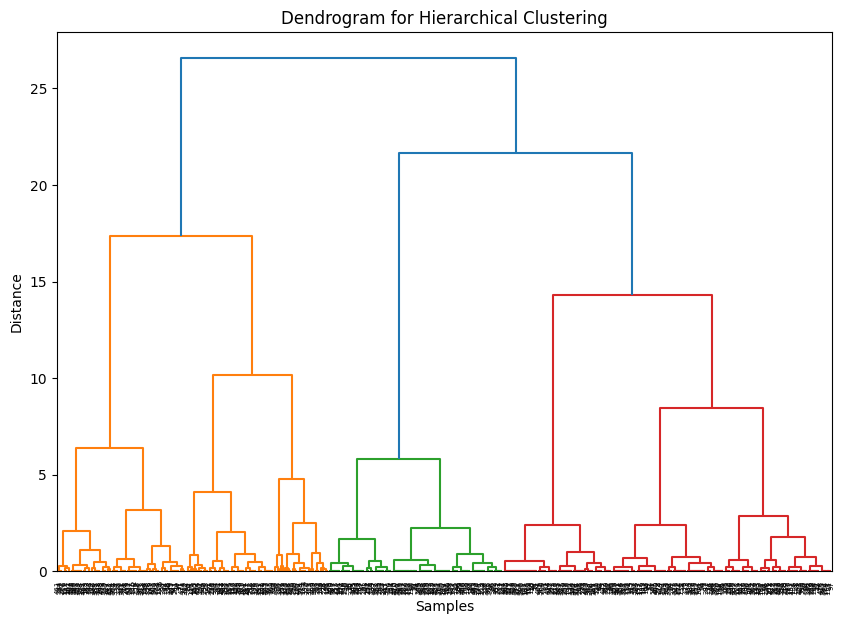

Silhouette Score for Hierarchical Clustering: 0.5876938907473171


In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Linkage matrix
linkage_matrix = linkage(features_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# Fit Agglomerative Clustering
hierarchical = AgglomerativeClustering(n_clusters=8)
clusters_hierarchical = hierarchical.fit_predict(features_scaled)

# Evaluate
score_hierarchical = silhouette_score(features_scaled, clusters_hierarchical)
print('Silhouette Score for Hierarchical Clustering:', score_hierarchical)


<h2>Understanding Hierarchical Clustering Outcomes</h2>
<p>The dendrogram produced from our hierarchical clustering offers a visual representation of the data's cluster hierarchy. This tree-like diagram allows us to observe the sequence of cluster formations and the distances (or dissimilarities) at which they merged. Hierarchical clustering has presented us with an alternative perspective on our dataset's intrinsic grouping, as reflected by the different color-coded linkage levels on the dendrogram.</p>
<p>Upon examining the dendrogram for hierarchical clustering, we can identify several distinct clusters at various levels of similarity. The significant vertical distances between horizontal lines suggest a strong structure and clear separation between certain clusters.</p>
<p><strong>Conclusion: </strong>The silhouette score obtained for hierarchical clustering stands at 0.5876, indicating moderately well-defined clusters. Although this score is relatively high, it does not surpass the tight clustering achieved by KMeans. Ultimately, hierarchical clustering has the advantage of revealing the multi-layered structure of data groupings that may not be immediately apparent with other clustering techniques.</p>



<h1> Final Conclusion </h3>

In the end, KMeans clustering provided clear and definitive groupings based on our initial feature set, while DBSCAN offered insights into the density and distribution of these businesses, highlighting outliers and unique spots. Hierarchical clustering added an additional layer of understanding by revealing the inherent structure and relationships between data points. Finally, PCA showed us that factor extraction can be important in data mining.

Thus, by cross-validating with these algorithms, we ensured that our findings are robust and reliable. The silhouette score served as a useful metric to evaluate the quality of the clusters formed, ensuring that the selected establishments are indeed representative of what one might consider a hidden gem.

We are confident that through this project we will be able to have a more enjoyable experience during our next trip to New Orleans and allow us to use this type of data mining for future travel plans.